<a href="https://colab.research.google.com/github/kpapdac/graphicalModels/blob/main/pgmpy_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pgmpy

     |████████████████████████████████| 1.9 MB 6.5 MB/s 


### CPD for Discrete Variables

Create network structure

In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
import pandas as pd
import numpy as np
model = BayesianNetwork([('A', 'B'), ('B', 'C'), ('A', 'D'), ('D', 'C')])

Create CPDs from dataframe

In [7]:
values = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000, 4)), columns=['A', 'B', 'C', 'D'])
model.fit(values)
model.get_cpds()

[<TabularCPD representing P(A:2) at 0x7f00ed7b3410>,
 <TabularCPD representing P(B:2 | A:2) at 0x7f00ef08ded0>,
 <TabularCPD representing P(C:2 | B:2, D:2) at 0x7f00ef028f10>,
 <TabularCPD representing P(D:2 | A:2) at 0x7f00ef08df50>]

Check model validity

In [8]:
model.check_model()

True

Manually assigning CPDs

In [9]:
model = BayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])
# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2,
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

True

### CPD for Continuous Variables

Dirichlet distribution of two continuous variables x and y

In [42]:
import numpy as np
from scipy.special import beta

# Two variable dirichlet ditribution with alpha = (1,2)
def dirichlet_pdf(x, y):
     return (np.power(x, 1)*np.power(y, 2))/beta(1,2)

from pgmpy.factors.continuous import ContinuousFactor
dirichlet_factor = ContinuousFactor(['x', 'y'], dirichlet_pdf)
dirichlet_factor.scope(), dirichlet_factor.assignment(5,6)

(['x', 'y'], 360.0)

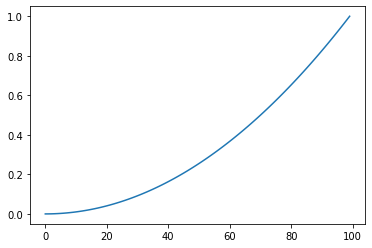

In [38]:
import matplotlib.pyplot as plt
plt.plot(dirichlet_pdf(np.linspace(0,1,100),1))

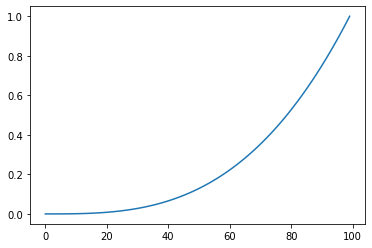

In [40]:
import matplotlib.pyplot as plt
plt.plot(dirichlet_pdf(1, np.linspace(0,1,100)))

Multivariate normal distribution for continuous variables x1 and x2

In [41]:
from scipy.stats import multivariate_normal

std_normal_pdf = lambda *x: multivariate_normal.pdf(x, [0, 0], [[1, 0], [0, 1]])
std_normal = ContinuousFactor(['x1', 'x2'], std_normal_pdf)
std_normal.scope(), std_normal.assignment([1, 1])

(['x1', 'x2'], 0.05854983152431917)

Most common distribution for continuous variables is Linear Gaussian CPD

In [9]:
from pgmpy.factors.continuous import LinearGaussianCPD
cpd = LinearGaussianCPD('Y',  [9, -2, 3, 8], 9.6, ['X1', 'X2', 'X3'])
print(cpd)

P(Y | X1, X2, X3) = N(9*X1 + -2*X2 + 3*X3 + 9; 9.6)


In [17]:
cpd.variable, cpd.evidence, cpd.mean

('Y', ['X1', 'X2', 'X3'], [9, -2, 3, 8])

Joint Linear Gaussian CPDs

In [18]:
from pgmpy.models import LinearGaussianBayesianNetwork

model = LinearGaussianBayesianNetwork([('x1', 'x2'), ('x2', 'x3')])
cpd1 = LinearGaussianCPD('x1', [1], 4)
cpd2 = LinearGaussianCPD('x2', [-5, 0.5], 4, ['x1'])
cpd3 = LinearGaussianCPD('x3', [4, -1], 3, ['x2'])
# This is a hack due to a bug in pgmpy (LinearGaussianCPD
# doesn't have `variables` attribute but `add_cpds` function
# wants to check that...)
cpd1.variables = [*cpd1.evidence, cpd1.variable]
cpd2.variables = [*cpd2.evidence, cpd2.variable]
cpd3.variables = [*cpd3.evidence, cpd3.variable]
model.add_cpds(cpd1, cpd2, cpd3)
jgd = model.to_joint_gaussian()
jgd.variables

['x1', 'x2', 'x3']

In [19]:
jgd.mean

array([[  1.],
       [-10.],
       [-36.]])

In [30]:
cpd2.pdf((-5,0.2))

array([0.19947114, 0.00679148])

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


In [11]:
model.check_model()

True

In [ ]:

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2,
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()